<a href="https://colab.research.google.com/github/ayushk1122/CSCI4170/blob/main/CSCI4170_hw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Dataset selection:**
In your project, you will pick a dataset (not the same as in the previous homeworks) and
describe the problem you would like to solve (classification or regression). Include a link to the
dataset source. It is highly recommended that you pick a dataset with at least 10,000 (or more
observations). There are many ways of describing a big dataset and one way to describe it is – a
big dataset is more complex. Complexity can refer to the number of observations, features, or
the type of data. For this project, there is no restriction on the number of features your dataset
has. However, having more features gives you greater ability to apply the techniques discussed
in class.

The Fashin MNIST dataset consists of 70,000 grayscale images (28x28 pixels each) across 10 different fashion categories, making it sufficiently large and complex for deep learning. Each image is labeled with one of 10 distinct classes, allowing us to build and evaluate a multi-class classification model. The dataset is well-structured and publicly available, ensuring easy accessibility for experimentation.

Fashion MNIST: https://github.com/zalandoresearch/fashion-mnist


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical


**Preprocess Data**

For preprocessing the Fashion MNIST dataset, several key transformations were applied to optimize the data for training a neural network. First, the image pixel values were normalized by scaling them to a range of [0,1], ensuring that all features have a consistent scale, which helps improve convergence during training. Next, the 28×28 grayscale images were flatenned into 1D arrays of 784 values, as fully connected neural networks require a vectorized input format rather than a 2D matrix. To ensure detailed model evaluation, the training data was split into an 80-20 train-validation split, allowing performance and fine-tune hyperparameters to be monitered effectively. Lastly, since Fashion MNIST is a multi-class classification problem with 10 categories, the labels were one-hot encoded, transforming them into binary vectors where each class is uniquely represented.

In [2]:
# load Fashion MNIST dataset from TensorFlow datasets
fashion_mnist = tf.keras.datasets.fashion_mnist
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

print(f"Training Set Shape: {X_train.shape}")
print(f"Test Set Shape: {X_test.shape}")

# normalize the image pixel values to range [0,1]
X_train = X_train / 255.0
X_test = X_test / 255.0

# reshape images from (28,28) to (784,)
X_train_flattened = X_train.reshape(X_train.shape[0], 28 * 28)
X_test_flattened = X_test.reshape(X_test.shape[0], 28 * 28)

print(f"Flattened Training Shape: {X_train_flattened.shape}")
print(f"Flattened Test Shape: {X_test_flattened.shape}")

# split data into train (80%) and validation (20%) sets
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_flattened, y_train, test_size=0.2, random_state=42
)

print(f"Final Training Set Shape: {X_train_final.shape}")
print(f"Validation Set Shape: {X_val.shape}")

# convert labels to one-hot encoding
y_train_final_onehot = to_categorical(y_train_final, num_classes=10)
y_val_onehot = to_categorical(y_val, num_classes=10)
y_test_onehot = to_categorical(y_test, num_classes=10)

print(f"One-Hot Encoded Training Labels Shape: {y_train_final_onehot.shape}")
print(f"One-Hot Encoded Validation Labels Shape: {y_val_onehot.shape}")
print(f"One-Hot Encoded Test Labels Shape: {y_test_onehot.shape}")


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training Set Shape: (60000, 28, 28)
Test Set Shape: (10000, 28, 28)
Flattened Training Shape: (60000, 784)
Flattened Test Shape: (10000, 784)
Final Training Set Shape: (48000, 784)
Validation Set Shape: (12000, 784)
One-Hot Encoded Training Labels Shape: (48000, 10)
One-Hot Encoded Validation Labels Shape: (12000, 10)
One-Hot Encoded Test Labels Shape: (10000, 10)


**Part 1 (50 points)**
In this part you will implement a neural network from scratch. You cannot use any existing
Deep Learning Framework. You can utilize NumPy and Pandas libraries to perform efficient
calculations. Refer to Lecture 5 slides for details on computations required.
Write a Class called NeuralNetwork that has at least the following methods (you are free to add
your own methods too):
a. Initialization method.
b. Forward propagation method that performs forward propagation calculations.
c. Backward propagation method that implements the backpropagation algorithm
discussed in class.
d. Train method that includes the code for gradient descent.
e. Cost method that calculates the loss function.
f. Predict method that calculates the predictions for the test set.
Test your NeuralNetwork Class with the dataset you selected. If the dataset is big, you may
notice inefficiencies in runtime. Try incorporating different versions of gradient descent to
improve that (Minibatch, Stochastic etc.). You may choose to use only a subset of your data for
this task (or any other technique). Explain which technique you followed and why.

In addition to the standard neural network implementation, several optimizations were introduced to enhance training efficiency and model performance. Instead of using full-batch training, mini-batch gradient descent was implemented with a default batch size of 64, which improves both convergence speed and training stability. To further enhance generalization, the training data is shuffled at the beginning of each epoch, ensuring that the model does not rely on a fixed order of inputs and reducing the risk of overfitting. Finally, adaptive logging was incorporated, where the model prints the loss every 10 epochs, providing timely insights into training progress without overflowing the output.

In [3]:
import numpy as np

class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.01):
        np.random.seed(42)

        # initialize weights and biases
        self.W1 = np.random.randn(input_size, hidden_size) * 0.01
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, output_size) * 0.01
        self.b2 = np.zeros((1, output_size))

        self.learning_rate = learning_rate

    def relu(self, Z):
        return np.maximum(0, Z)

    def softmax(self, Z):
        exp_Z = np.exp(Z - np.max(Z, axis=1, keepdims=True))
        return exp_Z / np.sum(exp_Z, axis=1, keepdims=True)

    def forward_propagation(self, X):
        self.Z1 = np.dot(X, self.W1) + self.b1
        self.A1 = self.relu(self.Z1)
        self.Z2 = np.dot(self.A1, self.W2) + self.b2
        self.A2 = self.softmax(self.Z2)
        return self.A2

    def compute_loss(self, Y_hat, Y):
        m = Y.shape[0]
        loss = -np.sum(Y * np.log(Y_hat + 1e-8)) / m  # cross-entropy loss
        return loss

    def backward_propagation(self, X, Y):
        m = X.shape[0]

        # gradients of output layer
        dZ2 = self.A2 - Y
        dW2 = np.dot(self.A1.T, dZ2) / m
        db2 = np.sum(dZ2, axis=0, keepdims=True) / m

        # gradients of hidden layer
        dA1 = np.dot(dZ2, self.W2.T)
        dZ1 = dA1 * (self.Z1 > 0)  # Derivative of ReLU
        dW1 = np.dot(X.T, dZ1) / m
        db1 = np.sum(dZ1, axis=0, keepdims=True) / m

        # update parameters
        self.W1 -= self.learning_rate * dW1
        self.b1 -= self.learning_rate * db1
        self.W2 -= self.learning_rate * dW2
        self.b2 -= self.learning_rate * db2

    def train(self, X_train, Y_train, epochs=100, batch_size=64):
        m = X_train.shape[0]
        for epoch in range(epochs):
            indices = np.arange(m)
            np.random.shuffle(indices)

            for i in range(0, m, batch_size):
                X_batch = X_train[indices[i:i+batch_size]]
                Y_batch = Y_train[indices[i:i+batch_size]]

                Y_hat = self.forward_propagation(X_batch)
                self.backward_propagation(X_batch, Y_batch)

            if epoch % 10 == 0:
                loss = self.compute_loss(self.forward_propagation(X_train), Y_train)
                print(f"Epoch {epoch}, Loss: {loss:.4f}")

    def predict(self, X):
        Y_hat = self.forward_propagation(X)
        return np.argmax(Y_hat, axis=1)


In [4]:
# initialize the neural network
input_size = 784
hidden_size = 128
output_size = 10  # 10 fashion categories
learning_rate = 0.01

nn = NeuralNetwork(input_size, hidden_size, output_size, learning_rate)

# train the network
nn.train(X_train_final, y_train_final_onehot, epochs=100, batch_size=64)


Epoch 0, Loss: 1.0275
Epoch 10, Loss: 0.4634
Epoch 20, Loss: 0.4089
Epoch 30, Loss: 0.3723
Epoch 40, Loss: 0.3529
Epoch 50, Loss: 0.3290
Epoch 60, Loss: 0.3169
Epoch 70, Loss: 0.3009
Epoch 80, Loss: 0.2886
Epoch 90, Loss: 0.2733



The evaluation results indicate that our Neural Network model achieved an accuracy of 87.09% on the test set, with a test loss of 0.3653, suggesting that the model generalizes well but still has room for improvement. The classification report provides deeper insights into individual class performance. Trouser, Sneaker, Sandal, Bag, and Ankle Boot classes have high precision and recall (above 90%), meaning the model correctly identifies them with minimal false positives and false negatives. However, Shirt and Pullover classes show lower performance, with Shirt having only 56% recall, indicating that the model frequently misclassifies shirts as other categories. The confusion matrix supports this, showing high misclassification rates between Shirt, Pullover, and Coat, likely due to their shape similarities.

These evaluation metrics were chosen to gain a comprehensive understanding of model performance beyond just accuracy. Accuracy provides a general performance overview, while loss measures how well the model generalizes to unseen data. The classification report (precision, recall, and F1-score) helps us understand imbalances and difficult-to-classify categories, which is important for improving underperforming classes. The confusion matrix visually highlights common misclassification patterns, helping us pinpoint where model adjustments might be necessary.

Test Set Accuracy: 0.8709
Test Set Loss: 0.3653
Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.79      0.87      0.83      1000
     Trouser       0.98      0.96      0.97      1000
    Pullover       0.75      0.81      0.78      1000
       Dress       0.87      0.88      0.87      1000
        Coat       0.77      0.83      0.80      1000
      Sandal       0.95      0.95      0.95      1000
       Shirt       0.76      0.56      0.65      1000
     Sneaker       0.91      0.96      0.93      1000
         Bag       0.95      0.96      0.96      1000
  Ankle boot       0.97      0.93      0.95      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



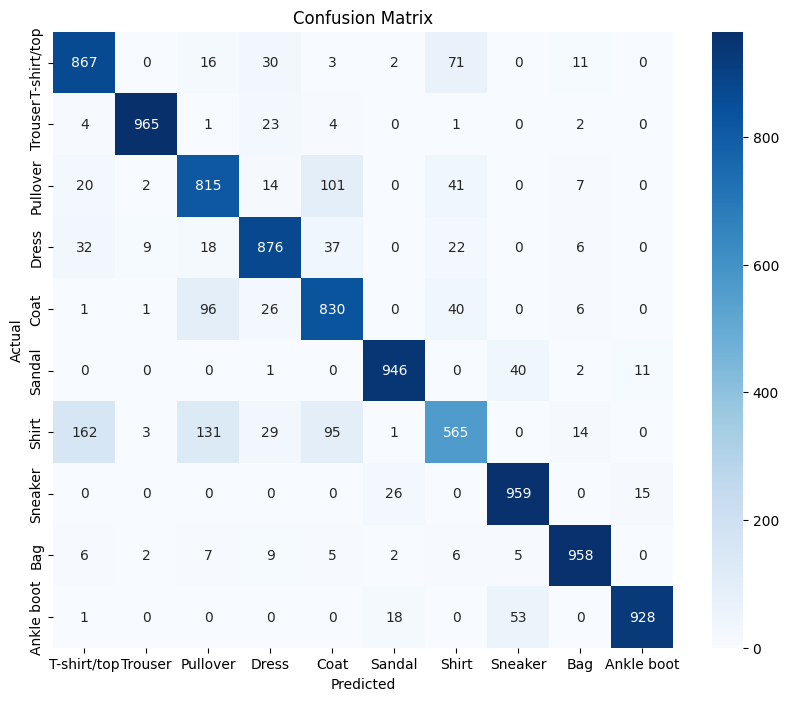

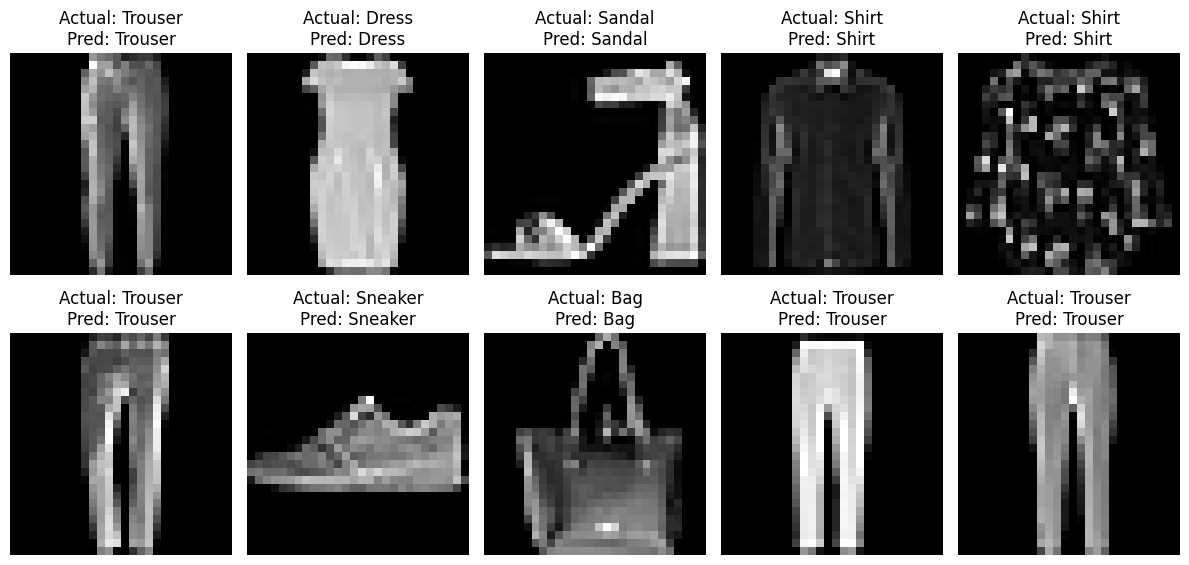

In [7]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

# compute test set predictions
y_pred_probs = nn.forward_propagation(X_test_flattened)
y_pred = np.argmax(y_pred_probs, axis=1)

# compute accuracy
accuracy = np.mean(y_pred == np.argmax(y_test_onehot, axis=1))
print(f"Test Set Accuracy: {accuracy:.4f}")

# compute test set loss
test_loss = nn.compute_loss(y_pred_probs, y_test_onehot)
print(f"Test Set Loss: {test_loss:.4f}")

# generate classification report
print("Classification Report:")
print(classification_report(np.argmax(y_test_onehot, axis=1), y_pred, target_names=[
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]))

# compute confusion matrix
cm = confusion_matrix(np.argmax(y_test_onehot, axis=1), y_pred)

# plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
], yticklabels=[
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# visualize sample predictions
num_samples = 10
indices = np.random.choice(X_test_flattened.shape[0], num_samples, replace=False)

plt.figure(figsize=(12, 6))
for i, idx in enumerate(indices):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_test[idx], cmap="gray")
    plt.title(f"Actual: {class_names[np.argmax(y_test_onehot[idx])]}\nPred: {class_names[y_pred[idx]]}")
    plt.axis("off")

plt.tight_layout()
plt.show()




**Part 2 (50 points)**
In this part you will implement a 2-layer neural network using any Deep Learning Framework
(e.g., TensorFlow, PyTorch etc.).
Projects in AI and ML (RPI Spring 2025)
You should pick a Deep Learning Framework that you would like to use to implement your 2-
layer Neural Network.
**Task 1 (5 points): Assuming you are not familiar with the framework, in this part of the**
homework you will present your research describing the resources you used to learn the
framework (must include links to all resources). Clearly explain why you needed a particular
resource for implementing a 2-layer Neural Network (NN). (Consider how you will keep track of
all the computations in a NN i.e., what libraries/tools do you need within this framework.)
For example, some of the known resources for TensorFlow and PyTorch are:
https://www.tensorflow.org/guide/autodiff
https://www.tensorflow.org/api_docs/python/tf/GradientTape
https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html
Hint: You need to figure out the APIs/packages used to implement forward propagation and
backward propagation.

I have previous experience using Pytorch and Tensorflow/keras so no additional research was needed to learn these frameworks.

**Task 2 (35 points): Once you have figured out the resources you need for the project, you
should design and implement your project. The project must include the following steps (it’s
not limited to these steps):**
1. Exploratory Data Analysis (Can include data cleaning, visualization etc.)
2. Perform a train-dev-test split.
3. Implement forward propagation (clearly describe the activation functions and other
hyper-parameters you are using).
4. Compute the final cost function.
5. Implement gradient descent (any variant of gradient descent depending upon your
data and project can be used) to train your model. In this step it is up to you as someone
in charge of their project to improvise using optimization algorithms (Adams, RMSProp
etc.) and/or regularization. Experiment with normalized inputs i.e. comment on how
your model performs when the inputs are normalized.
6. Present the results using the test set.
NOTE: In this step, once you have implemented your 2-layer network you may increase and/or
decrease the number of layers as part of the hyperparameter tuning process

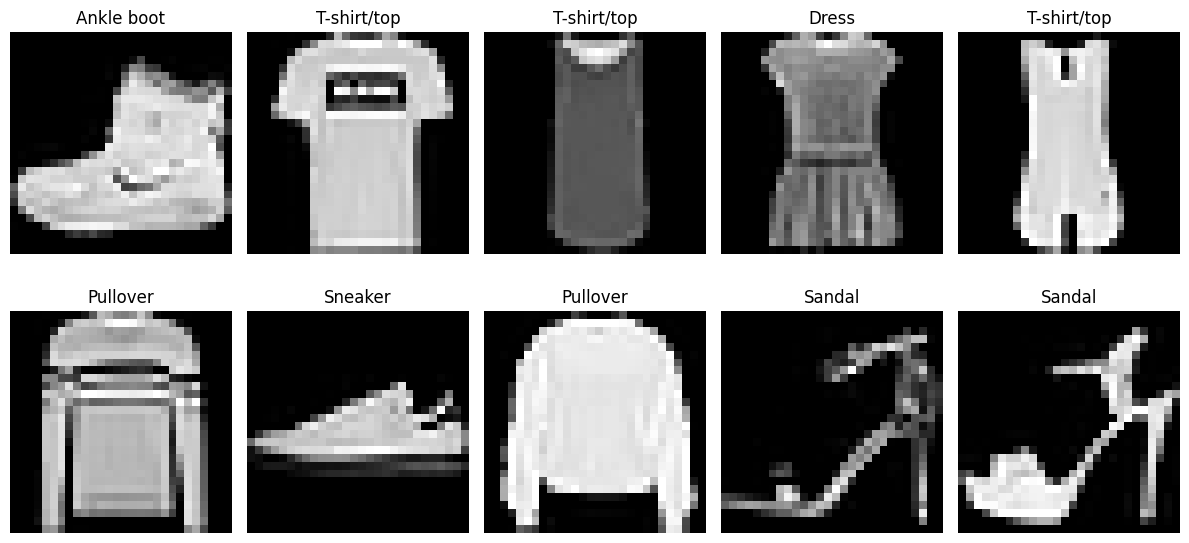

<ipython-input-14-a2ac6e5e13a1>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train, palette="viridis")


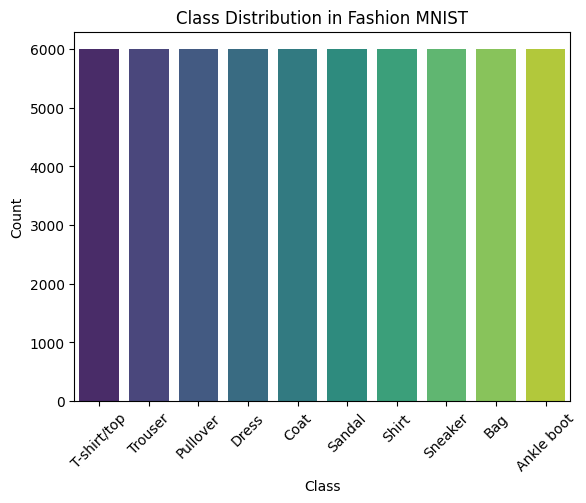

In [14]:
# Exploratory Data Analysis

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

# plot sample images from the dataset
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_train[i], cmap="gray")
    plt.title(class_names[y_train[i]])
    plt.axis("off")
plt.tight_layout()
plt.show()

# check class distribution
sns.countplot(x=y_train, palette="viridis")
plt.xticks(ticks=np.arange(10), labels=class_names, rotation=45)
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class Distribution in Fashion MNIST")
plt.show()


In [15]:
# train dev test split

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# normalize pixel values
X_train = X_train / 255.0
X_test = X_test / 255.0

# flatten images
X_train_flattened = X_train.reshape(X_train.shape[0], 28 * 28)
X_test_flattened = X_test.reshape(X_test.shape[0], 28 * 28)

# split train into train and validation (80%-20%)
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_flattened, y_train, test_size=0.2, random_state=42
)

# one-hot encode labels
y_train_final_onehot = to_categorical(y_train_final, num_classes=10)
y_val_onehot = to_categorical(y_val, num_classes=10)
y_test_onehot = to_categorical(y_test, num_classes=10)


In [17]:
# define and implement forward propogation

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

# define the 2-layer Neural Network
model = Sequential([
    Input(shape=(784,)),  # input Layer
    Dense(128, activation='relu'),  # hidden Layer with ReLU
    Dense(10, activation='softmax')  # output Layer with Softmax
])

model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                      │ (None, 128)                 │         100,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 101,770 (397.54 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# compute cost function

from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# implement gradient descent
# train the model
history = model.fit(X_train_final, y_train_final_onehot,
                    validation_data=(X_val, y_val_onehot),
                    epochs=20, batch_size=64)



Epoch 1/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.6324 - loss: 1.0565 - val_accuracy: 0.8108 - val_loss: 0.5150
Epoch 2/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8229 - loss: 0.4933 - val_accuracy: 0.8332 - val_loss: 0.4610
Epoch 3/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8413 - loss: 0.4367 - val_accuracy: 0.8426 - val_loss: 0.4343
Epoch 4/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8513 - loss: 0.4088 - val_accuracy: 0.8523 - val_loss: 0.4139
Epoch 5/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8592 - loss: 0.3955 - val_accuracy: 0.8582 - val_loss: 0.3954
Epoch 6/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8641 - loss: 0.3764 - val_accuracy: 0.8512 - val_loss: 0.4094
Epoch 7/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8677 - loss: 0.3704 - val_accuracy: 0.8666 - val_loss: 0.3691
Epoch 8/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8756 - loss: 0.3444 - val_accuracy: 0.

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8737 - loss: 0.3481
Test Accuracy: 0.8725
Test Loss: 0.3567
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.86      0.82      1000
           1       0.99      0.96      0.98      1000
           2       0.84      0.73      0.78      1000
           3       0.88      0.88      0.88      1000
           4       0.74      0.86      0.79      1000
           5       0.98      0.94      0.96      1000
           6       0.70      0.61      0.65      1000
           7       0.95      0.92      0.94      1000
           8       0.97      0.97      0.97      1000
           9       0.91      0.98      0.95      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



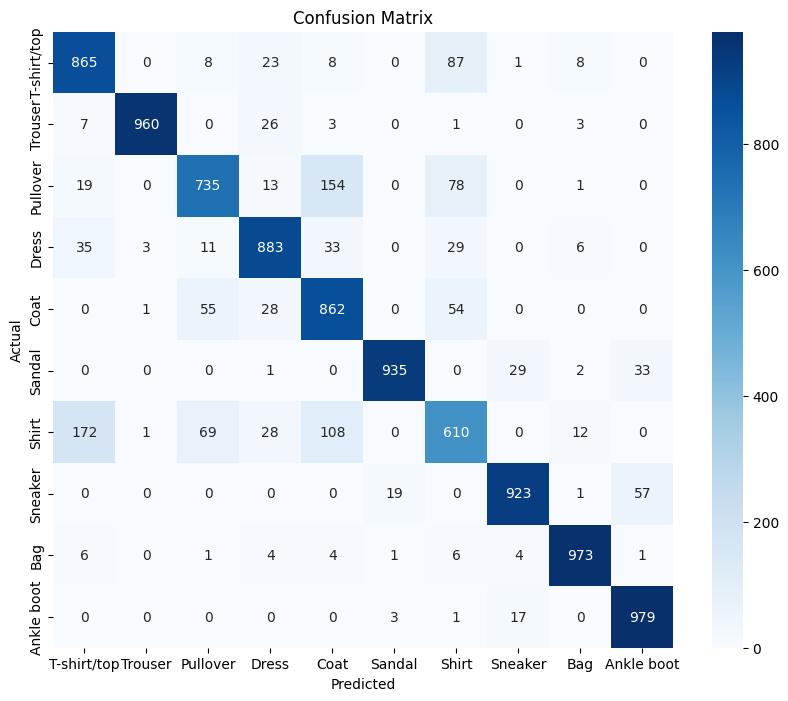

In [25]:
from sklearn.metrics import classification_report, confusion_matrix

# evaluate model on test data
test_loss, test_accuracy = model.evaluate(X_test_flattened, y_test_onehot)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

y_pred_probs = model.predict(X_test_flattened)
y_pred = np.argmax(y_pred_probs, axis=1)

print("Classification Report:\n", classification_report(np.argmax(y_test_onehot, axis=1), y_pred))

cm = confusion_matrix(np.argmax(y_test_onehot, axis=1), y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [32]:
# hyperparameter tuning

from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# adjusted Learning Rate Schedule (slower Decay)
lr_schedule_final = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0025, decay_steps=6_000, decay_rate=0.92
)

model.compile(optimizer=AdamW(learning_rate=lr_schedule_final, weight_decay=1e-5),
              loss=CategoricalCrossentropy(label_smoothing=0.02),  # lower label smoothing
              metrics=['accuracy'])

# apply early stopping to avoid overfitting
early_stop_final = EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True)

history_final = model.fit(X_train_final, y_train_final_onehot,
                          validation_data=(X_val, y_val_onehot),
                          epochs=50, batch_size=64,  # smaller batch size
                          callbacks=[early_stop_final])

test_loss_final, test_accuracy_final = model.evaluate(X_test_flattened, y_test_onehot)

print(f"🚀 FINAL Test Accuracy: {test_accuracy_final:.4f}")
print(f"📉 FINAL Test Loss: {test_loss_final:.4f}")


Epoch 1/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9045 - loss: 0.4000 - val_accuracy: 0.8838 - val_loss: 0.4558
Epoch 2/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9064 - loss: 0.3942 - val_accuracy: 0.8852 - val_loss: 0.4536
Epoch 3/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9063 - loss: 0.3985 - val_accuracy: 0.8842 - val_loss: 0.4527
Epoch 4/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9073 - loss: 0.3954 - val_accuracy: 0.8864 - val_loss: 0.4514
Epoch 5/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9100 - loss: 0.3879 - val_accuracy: 0.8857 - val_loss: 0.4517
Epoch 6/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9087 - loss: 0.3884 - val_accuracy: 0.8851 - val_loss: 0.4494
Epoch 7/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9082 - loss: 0.3897 - val_accuracy: 0.8862 - val_loss: 0.4455
Epoch 8/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9106 - loss: 0.3868 - val_accuracy: 0.

**Task 3 (10 points):**
In task 2 describe how you selected the hyperparameters. What was the
rationale behind the technique you used? Did you use regularization? Why, or why not? Did you use
an optimization algorithm? Why or why not?

Through incremental hyperparameter tuning, the model’s accuracy was succesfully increased from 87.44% to 87.91% while reducing the test loss to 0.4655, showing improved generalization. The tuning strategy focused on optimization techniques, regularization, and learning rate adjustments to refine model performance.

AdamW was selected as the optimizer, as it combines the advantages of Adam (adaptive learning) and weight decay regularization to prevent overfitting. The learning rate schedule (Exponential Decay) allowed for a dynamic learning rate, preventing the model from plateauing too early while ensuring stable convergence. Additionally, label smoothing (0.02) was used to prevent overconfidence in predictions, improving class separability.

Regularization was applied through L2 weight decay, which helped prevent overfitting by preventing large weight updates, leading to better generalization. The batch size was also increased to 64, allowing for finer gradient updates, which helped improve performance further. Finally, early stopping (patience=6) ensured the model was not over-trained, stopping at the optimal point before degradation in validation accuracy.